In [1]:
#pip3 install google.colab
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

###  Libraries

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors

import torch

import os
import sys

from Autoencoder import Autoencoder, CD_Autoencoder
from Datasets.Datasets_Functions import *
from Visualization import Visualization
from Evaluations.Evaluation import Evaluator
from General_Functions import General_Functions

### Global Variables

In [3]:
path_to_module = './' # 'C:\\Users\\PAPASOFT INC\\Desktop\\SOFT_SIL'
sys.path.append(path_to_module)
os.environ['OMP_NUM_THREADS'] = '6'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

### Visualization

In [4]:
visualization = Visualization()

### ***LOAD DATASET***

In [5]:
hashmap_path = path_to_module + 'Datasets/'
hashmap = get_hashmap(hashmap_path)
dataset_name = 'emnist_balanced_digits'

dataset_properties = hashmap[dataset_name]
print(dataset_properties)

dataloader, input_dim, data_np, labels = function_get_dataset(dataset_name, dataset_properties)
batch_size = dataset_properties['batch_size'] = 100
print('Data_Shape is:', input_dim)
print('Batches Number is:', len(dataloader))

{'batch_size': 1024, 'n_clusters': 10, 'module_name': 'Datasets.Datasets'}
Data_Shape is: 1
Batches Number is: 28


### Parameters

In [6]:
# Latent Dimension, Number of Channels and Negative Slope
latent_dim = 10
n_channels = 1
n_clusters = dataset_properties['n_clusters']

# Batch Size and Number of Clusters
batch_size = dataset_properties['batch_size']
negative_slope = 0

# Pre-Training Epochs and Learning Rate
n_pret_epochs = 100
pret_lr = 1e-3

# Lamdas, Training Epochs and Learning Rate
n_epochs = 100
lr = 5e-4
sil_lambda = 0.02
entr_lambda = 0.02

kmeans_initialization = True
pretrain = False
is_MLP_AE = False

### Create Autoencoder Model

In [7]:
if is_MLP_AE:
    autoencoder = Autoencoder(device=device, n_clusters=n_clusters, input_dim=input_dim, latent_dim=latent_dim, negative_slope=negative_slope)
    autoencoder.set_general_training_variables(dataloader=dataloader, batch_size=batch_size)
    autoencoder.set_pretraining_variables(n_pret_epochs=n_pret_epochs, pret_lr=pret_lr)
    autoencoder.set_training_variables(n_epochs=n_epochs, lr=lr, sil_lambda=sil_lambda, entr_lambda=entr_lambda)
    autoencoder.set_path_variables(path_to_module=path_to_module, dataset_name=dataset_name)
    autoencoder.set_path()
else:
    autoencoder = CD_Autoencoder(device=device, n_clusters=n_clusters, input_dim=input_dim, latent_dim=latent_dim, negative_slope=negative_slope, n_channels=n_channels)
    autoencoder.set_general_training_variables(dataloader=dataloader, batch_size=batch_size)
    autoencoder.set_pretraining_variables(n_pret_epochs=n_pret_epochs, pret_lr=pret_lr)
    autoencoder.set_training_variables(n_epochs=n_epochs, lr=lr, sil_lambda=sil_lambda, entr_lambda=entr_lambda)
    autoencoder.set_path_variables(path_to_module=path_to_module, dataset_name=dataset_name)
    autoencoder.set_path()

autoencoder = autoencoder.to(device)

In [8]:
autoencoder

CD_Autoencoder(
  (encoder_model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0, inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): LeakyReLU(negative_slope=0, inplace=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (7): LeakyReLU(negative_slope=0, inplace=True)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1152, out_features=10, bias=True)
    (11): Tanh()
    (12): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cluster_model): Sequential(
    (0): RBF()
  )
  (decoder_model): Sequential(
    (0): Linear(in_feature

### Pretrain Autoencoder

In [9]:
if(pretrain):
    autoencoder.pretrain_autoencoder()
    autoencoder.save_pretrained_weights()
else:
    model_save_path = autoencoder.data_dir_path + '/Weigths/autoencoder_weights.pth'
    autoencoder.load_state_dict(torch.load(model_save_path))

### Initialize the clustering layer using k-means

In [10]:
n_inits = 100
if kmeans_initialization: autoencoder.kmeans_initialization(n_inits)

ACC: 0.79 PUR: 0.79 NMI: 0.73 ARI: 0.67


### Train Autoencoder

In [11]:
autoencoder.set_training_variables(n_epochs=100, lr=5e-4, sil_lambda=0.02, entr_lambda=0.02)
latent_data, labels, clustering = autoencoder.train_autoencoder()

Ep: 0 Rec L: 0.3308 Cl L: 0.5755 Entropy: 1.8324 SSil: -0.7762 SIL: 0.0000 ACC: 0.79 PUR: 0.79 NMI: 0.73 ARI: 0.67
Ep: 1 Rec L: 0.3050 Cl L: 0.5814 Entropy: 1.8037 SSil: -1.0716 SIL: 0.0000 ACC: 0.79 PUR: 0.79 NMI: 0.73 ARI: 0.67
Ep: 2 Rec L: 0.3090 Cl L: 0.5841 Entropy: 1.7885 SSil: -1.2052 SIL: 0.0000 ACC: 0.79 PUR: 0.79 NMI: 0.73 ARI: 0.66
Ep: 3 Rec L: 0.3151 Cl L: 0.5857 Entropy: 1.7806 SSil: -1.2868 SIL: 0.0000 ACC: 0.79 PUR: 0.79 NMI: 0.73 ARI: 0.66
Ep: 4 Rec L: 0.3113 Cl L: 0.5869 Entropy: 1.7720 SSil: -1.3463 SIL: 0.0000 ACC: 0.79 PUR: 0.79 NMI: 0.73 ARI: 0.66
Ep: 5 Rec L: 0.3106 Cl L: 0.5885 Entropy: 1.7641 SSil: -1.4254 SIL: 0.0000 ACC: 0.79 PUR: 0.79 NMI: 0.73 ARI: 0.66
Ep: 6 Rec L: 0.3126 Cl L: 0.5899 Entropy: 1.7587 SSil: -1.4957 SIL: 0.0000 ACC: 0.80 PUR: 0.80 NMI: 0.73 ARI: 0.67
Ep: 7 Rec L: 0.3115 Cl L: 0.5915 Entropy: 1.7501 SSil: -1.5751 SIL: 0.0000 ACC: 0.80 PUR: 0.80 NMI: 0.73 ARI: 0.67
Ep: 8 Rec L: 0.3121 Cl L: 0.5937 Entropy: 1.7383 SSil: -1.6872 SIL: 0.0000 ACC: 

Ep: 72 Rec L: 0.4410 Cl L: 0.3471 Entropy: 0.7162 SSil: 10.6452 SIL: 0.0000 ACC: 0.86 PUR: 0.86 NMI: 0.84 ARI: 0.79
Ep: 73 Rec L: 0.4429 Cl L: 0.3454 Entropy: 0.7140 SSil: 10.7297 SIL: 0.0000 ACC: 0.86 PUR: 0.86 NMI: 0.84 ARI: 0.79
Ep: 74 Rec L: 0.4355 Cl L: 0.3434 Entropy: 0.7122 SSil: 10.8315 SIL: 0.0000 ACC: 0.86 PUR: 0.86 NMI: 0.84 ARI: 0.79
Ep: 75 Rec L: 0.4276 Cl L: 0.3408 Entropy: 0.7076 SSil: 10.9585 SIL: 0.0000 ACC: 0.86 PUR: 0.86 NMI: 0.84 ARI: 0.79
Ep: 76 Rec L: 0.4316 Cl L: 0.3411 Entropy: 0.7077 SSil: 10.9457 SIL: 0.0000 ACC: 0.86 PUR: 0.86 NMI: 0.84 ARI: 0.79
Ep: 77 Rec L: 0.4406 Cl L: 0.3423 Entropy: 0.7080 SSil: 10.8837 SIL: 0.0000 ACC: 0.86 PUR: 0.86 NMI: 0.84 ARI: 0.79
Ep: 78 Rec L: 0.4371 Cl L: 0.3413 Entropy: 0.7080 SSil: 10.9343 SIL: 0.0000 ACC: 0.86 PUR: 0.86 NMI: 0.84 ARI: 0.79
Ep: 79 Rec L: 0.4441 Cl L: 0.3411 Entropy: 0.7084 SSil: 10.9469 SIL: 0.0000 ACC: 0.86 PUR: 0.86 NMI: 0.84 ARI: 0.79
Ep: 80 Rec L: 0.4352 Cl L: 0.3408 Entropy: 0.7054 SSil: 10.9579 SIL: 0.0

In [12]:
cluster_centers = autoencoder.get_cluster_centers().cpu().detach().numpy()
data, latent_data, labels = autoencoder.get_latent_data()

Directory './Results/emnist_balanced_digits/AE/100_Eps_ld_10_out_10_bs_100_lr_0.0005_sil_lambda_0.02_entr_lambda_0.02/Experiments/No_TSNE' already exists.


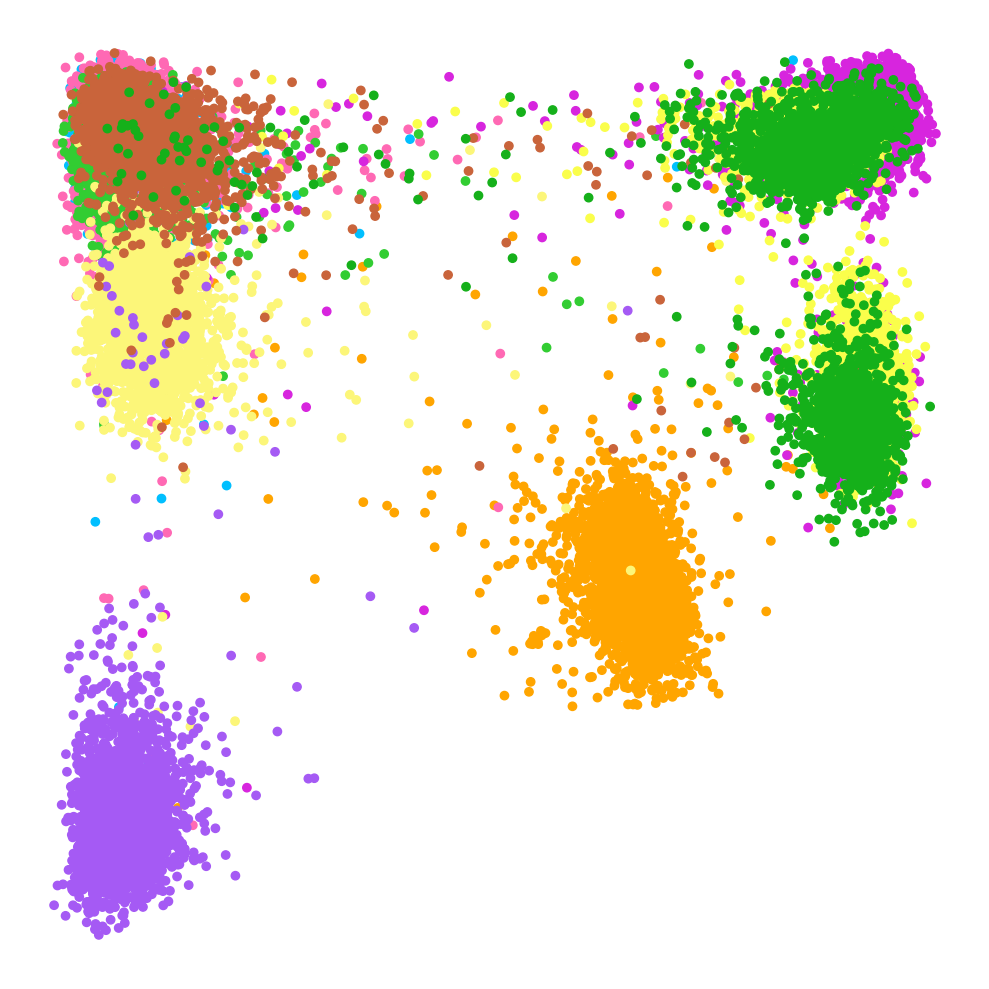

In [13]:
visualization.plot(latent_data, labels, clustering, cluster_centers, autoencoder.data_dir_path)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 28010 samples in 0.052s...
[t-SNE] Computed neighbors for 28010 samples in 1.179s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28010
[t-SNE] Computed conditional probabilities for sample 2000 / 28010
[t-SNE] Computed conditional probabilities for sample 3000 / 28010
[t-SNE] Computed conditional probabilities for sample 4000 / 28010
[t-SNE] Computed conditional probabilities for sample 5000 / 28010
[t-SNE] Computed conditional probabilities for sample 6000 / 28010
[t-SNE] Computed conditional probabilities for sample 7000 / 28010
[t-SNE] Computed conditional probabilities for sample 8000 / 28010
[t-SNE] Computed conditional probabilities for sample 9000 / 28010
[t-SNE] Computed conditional probabilities for sample 10000 / 28010
[t-SNE] Computed conditional probabilities for sample 11000 / 28010
[t-SNE] Computed conditional probabilities for sample 12000 / 28010
[t-SNE] Computed conditional probabilities for sam

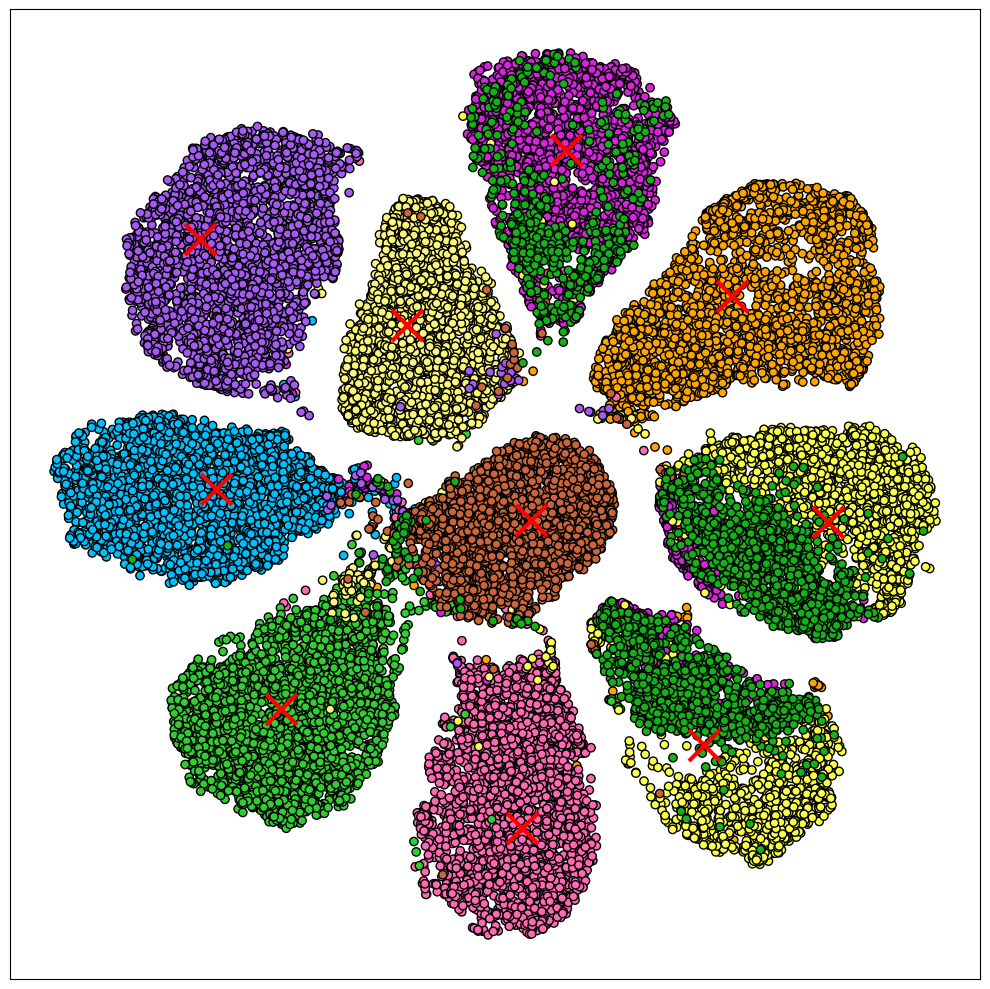

In [14]:
visualization.plot_tsne(latent_data, labels, clustering, cluster_centers, autoencoder.data_dir_path)

In [15]:
General_Functions().save_excel(autoencoder.data_dir_path, autoencoder.df_eval)

Directory './Results/emnist_balanced_digits/AE/100_Eps_ld_10_out_10_bs_100_lr_0.0005_sil_lambda_0.02_entr_lambda_0.02' already exists.


C:\Users\PAPASOFT INC\Documents\GitHub\Soft-Silhouette\General_Functions.py:23: FutureWarning: Setting the `book` attribute is not part of the public API, usage can give unexpected or corrupted results and will be removed in a future version
  writer.book = workbook
C:\Users\PAPASOFT INC\Documents\GitHub\Soft-Silhouette\General_Functions.py:27: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


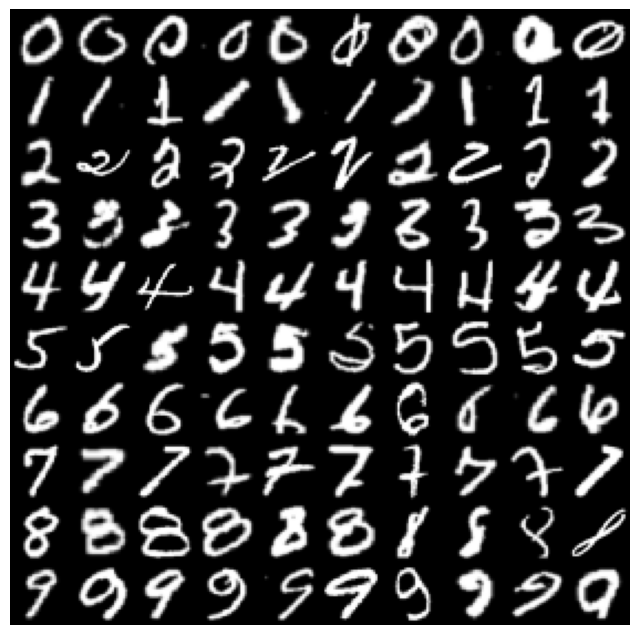

In [18]:
data, similarity, labels = autoencoder.get_similarity_data()
images = General_Functions().find_images_to_plot(0, 10, data, similarity, labels)
visualization.plot_collage(images, 10, 10, (28, 28), autoencoder.data_dir_path)